<a href="https://colab.research.google.com/github/huangcoder/python-learning/blob/main/Credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load datasets from Kaggle

In [ ]:
!pip install kaggle

In [ ]:
!mkdir .kaggle

In [ ]:
import json
token = {"username":"huangcoder","key":"a8700ce8a034c7046ceb379c516799bb"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              221KB  2021-03-25 09:54:53            937  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44            733  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27            686  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19            291  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Wo

In [ ]:
!kaggle datasets download -d mlg-ulb/creditcardfraud -p /content

creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip \*.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


# 0 Data Describe


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm
import lightgbm as lgb
%matplotlib inline 

In [ ]:
df=pd.read_csv("creditcard.csv")
df.head()  ##Return the first 5 rows

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.describe()   ## Generate descriptive statistics.

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


# 1 Data Analysis - by  Jiajie Xiong

In [ ]:
# Good No Null Values!
df.isnull().sum().max()

0

In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

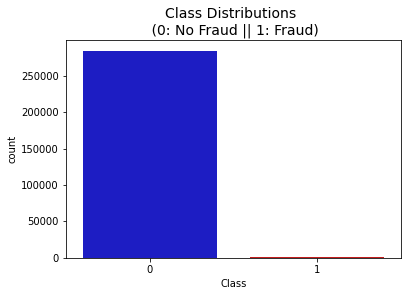

In [ ]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

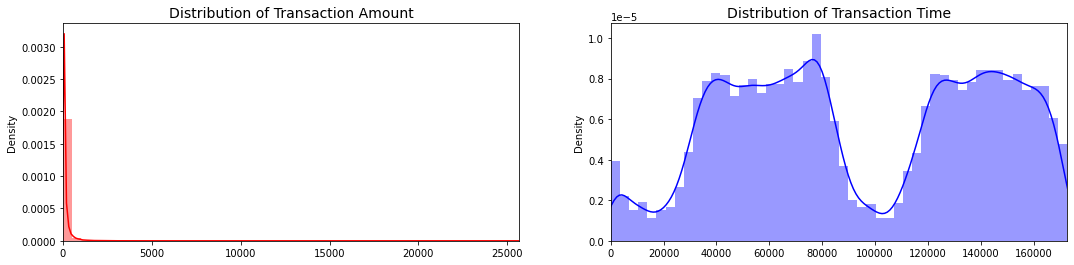

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

# 2 Use Smote to split datasets - by Yu lin

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc, average_precision_score
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def results(balancing_technique):
    print(balancing_technique)
    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6))
    model_name = ["RF", "XGB", "LGB", "CART"]
    RFC = RandomForestClassifier(random_state = 0)
    XGBC = XGBClassifier(random_state = 0)
    LGBC = LGBMClassifier(random_state = 0)
    CARTC = DecisionTreeClassifier(random_state = 0)

    for clf,i in zip([RFC, XGBC, LGBC, CARTC], model_name):
        model = clf.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:,1]
        print("#"*25,i,"#"*25)
        print("Training Accuracy = {:.3f}".format(model.score(X_train, y_train)))
        print("Test Accuracy = {:.3f}".format(model.score(X_test, y_test)))
        print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, y_pred)))
        #Confusion Matrix
        print(confusion_matrix(y_test, y_pred))
        print("-"*15,"CLASSIFICATION REPORT","-"*15)
        print(classification_report(y_test, y_pred))
        
        #precision-recall curve
        precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
        avg_pre = average_precision_score(y_test, y_pred_prob)
        ax1.plot(precision, recall, label = i+ " average precision = {:0.2f}".format(avg_pre), lw = 3, alpha = 0.7)
        ax1.set_xlabel('Precision', fontsize = 14)
        ax1.set_ylabel('Recall', fontsize = 14)
        ax1.set_title('Precision-Recall Curve (' + balancing_technique + ')', fontsize = 18)
        ax1.legend(loc = 'best')
        #find default threshold
        close_default = np.argmin(np.abs(thresholds_pr - 0.5))
        ax1.plot(precision[close_default], recall[close_default], 'o', markersize = 8)

        #roc-curve
        fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr,tpr)
        ax2.plot(fpr,tpr, label = i+ " area = {:0.2f}".format(roc_auc), lw = 3, alpha = 0.7)
        ax2.plot([0,1], [0,1], 'r', linestyle = "--", lw = 2)
        ax2.set_xlabel("False Positive Rate", fontsize = 14)
        ax2.set_ylabel("True Positive Rate", fontsize = 14)
        ax2.set_title("ROC Curve (" + balancing_technique + ")", fontsize = 18)
        ax2.legend(loc = 'best')
        #find default threshold
        close_default = np.argmin(np.abs(thresholds_roc - 0.5))
        ax2.plot(fpr[close_default], tpr[close_default], 'o', markersize = 8)
        plt.tight_layout()

In [3]:
X = df.drop(columns = 'Class')
y = df['Class']
#Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

NameError: ignored

Without Balancing
######################### RF #########################
Training Accuracy = 1.000
Test Accuracy = 0.999
ROC_AUC_score : 0.877510
[[85289     7]
 [   36   111]]
--------------- CLASSIFICATION REPORT ---------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.94      0.76      0.84       147

    accuracy                           1.00     85443
   macro avg       0.97      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443

######################### XGB #########################
Training Accuracy = 1.000
Test Accuracy = 0.999
ROC_AUC_score : 0.877504
[[85288     8]
 [   36   111]]
--------------- CLASSIFICATION REPORT ---------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.93      0.76      0.83       147

    accuracy                           1.00     85443
   macro a

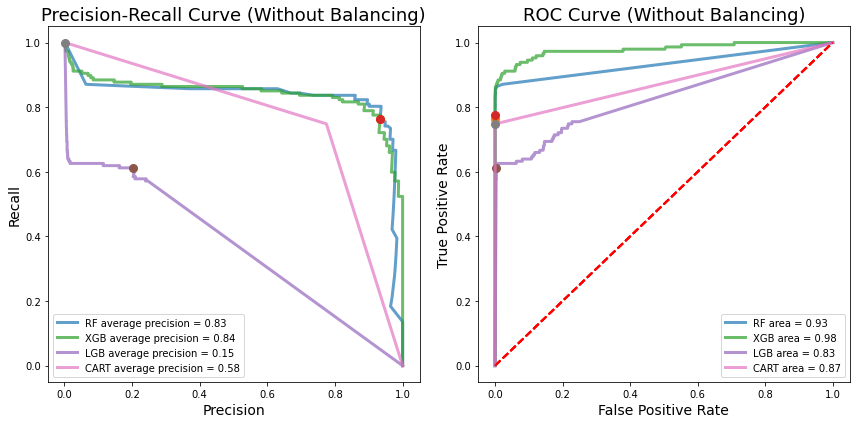

In [ ]:
results("Without Balancing")

# 3 Model Training



## Yu Lin：CART

## Jiajie：Random Forest

## Zhaoxing Weng：XGB

## Deshan Huang：LightGBM+deepforst

#4 Tuning parameters - by Zhaoxing Weng